In [12]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [ ]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')


In [36]:
config_list = [ 'cre_setup_1n_scale_1_node_info', 'cre_setup_1n_scale_5_node_info', 'cre_setup_1n_scale_3_node_info',\
              'cre_setup_1n_scale_4_node_info']



# config_list = ['cre_setup_2_scale_1_node_info']

# config_list2 = ['global_12cls',\
#                 'local_12cls',\
#                'global_3cls',\
#                'global_4cls',\
#                'global_6cls',\
#                'global_8cls',\
#                'global_2cls',\
#                'local_3cls',\
#                'local_4cls',\
#                'local_6cls',\
#                'local_8cls',\
#                'local_2cls']
# config_list2 = ['local_2cls']


config_list = config_list

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 1
8 1
9 -1
10 -1
11 -1
12 -1
13 1
14 1
15 1
16 1
17 1
18 -1
19 -1
0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'europe-west3-c'
12 12  'europe-west3-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'
17 17  'asia-south1-c'
18 18  'asia-south1-c'
19 19  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.21  34.159.183.47  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.7   34.107.29.210  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-19].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-17].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.8   34.89.255.174  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.28  34.107.57.28  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.36  35.234.115.93  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-19  asia-south1-c  e2-highmem-2               10.160.0.25  34.93.130.28  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-11].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.12  35.198.105.105  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.11  34.89.251.150  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-12].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.26  34.100.151.139  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-17  asia-south1-c  e2-highmem-2               10.160.0.27  34.93.251.66  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-12  europe-west3-c  e2-highmem-2               10.156.0.20  34.107.126.226  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-11  europe-west3-c  e2-highmem-2               10.156.0.30  34.141.68.143  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.25  35.198.99.97  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-16].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-18].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.51  34.141.91.50  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.48  34.159.15.226  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-16  asia-south1-c  e2-highmem-2               10.160.0.42  35.200.161.156  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.37  35.242.237.240  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-18  asia-south1-c  e2-highmem-2               10.160.0.68  34.93.46.31  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.30  34.93.125.65  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.55  34.100.190.17  RUNNING
test:  7001 10.156.0.37
test:  7002 10.156.0.25
test:  7003 10.156.0.30
test:  7004 10.156.0.20
test:  7005 10.160.0.68
test:  7006 10.160.0.25


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 2s
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 1s
1 actionable task: 1 executed

----------


----------


----------


----------

test:  0 10.156.0.12 10000 20000 0

test:  1 10.156.0.48 10000 20000 0

test:  2 10.156.0.21 10000 20000 0

test:  3 10.156.0.8 10000 20000 0

test:  4 10.156.0.11 10000 20000 0

test:  5 10.156.0.28 10000 20000 0

test:  6 10.156.0.7 10000 20000 0

test:  7 10.156.0.36 10000 20000 1

test:  8 10.156.0.51 10000 20000 1

test:  9 10.160.0.55 10000 20000 1

test:  10 10.160.0.26 10000 20000 1

test:  11 10.160.0.30 10000 20000 1

test:  12 10.160.0.42 10000 20000 1

test:  13 10.160.0.27 10000 20000 1

test:  7001 10.156.0.37 10000

test:  7002 10.156.0.25 10000

test:  7003 10.156.0.30 10000

test:  7004 10.156.0.20 10000

test:  7005 10.160.0.68 10000

test:  7006 10.160.0.25 10000

test:  0 10.156.0.12 10000 20000 0

test:  1 10.156.0.48 10000 20000 0

test:  2 10.156.0.21 10000 20000 0

test:  3 10.156.0.8 10000 20000 0

test:  4 10.156.0.11 10000 20000 0

test:  5 

To github.com:tmane002/BftSmart_Final.git
   8a4a24f2..3145ec5b  HEAD -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-12.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-48.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-21.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-8.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-11.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-7.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-36.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-51.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-37.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-25.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-30.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-20.us-west-1.compute.am

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://europe-we

Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1164 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2673 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [279 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [373 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:18 http://europe-west3.gce.archi

Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [279 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:23 http://security.ubuntu.com/ubuntu focal-security/main amd64 P

Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3095 kB]
Get:6 http://europe-west3.gce.archiv

Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:7 http://europe-west3.gce.archive.u

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2715 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [413 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2556 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [357 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://securit

Hit:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [373 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1164 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [279 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:22 http://asia-south1.gce.archive.u

Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2673 kB]
Get:35 http://security.ubuntu.com/ub

Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2715 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [413 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2556 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [357 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get

Reading package lists...
Building dependency tree...


Reading package lists...
Building dependency tree...
Reading state information...
Fetched 30.1 MB in 6s (5222 kB/s)
Reading package lists...
Reading state information...
Fetched 30.1 MB in 6s (5341 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcup

Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1

 


Building dependency tree...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs


Reading state information...
Reading package lists...1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.arc

Reading package lists...Reading package lists...Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]

Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Building dependency tree...
Building dependency tree...Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.arc

Reading package lists...1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-da

Reading package lists...Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]

Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 








The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
 

Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  u

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-171.189 [1131 kB]

Building dependency tree...Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 

Fetched 30.1 MB in 7s (4377 kB/s)
Reading package lists...Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxml

Building dependency tree...  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxx

Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 libj

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.0

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 li

Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-ra

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Fetched 48.2 MB in 1s (37.4 MB/s)
Building dependency tree...Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Reading package lists...Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package binutils-common:amd64.
Fetched 48.2 MB in 1s (33.7 MB/s)
  libc6g database ... 70%
1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-171.189 [1131 kB]
Fetched 48.2 MB in 2s (21.4 MB/s)
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-update

Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Selecting previously unselected package binutils.
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Get:33 http://europe-west3.gce.archive.ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Fetched 48.2 MB in 1s (42.6 MB/s)
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu foca



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline

Selecting previously unselected package libctf0:amd64.
Building dependency tree...Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previ

Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Selecting previously unselected package libc-dev-bin.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-g

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Selecting previously unselected package libisl22:amd64.
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Unpacking libcc1-0:amd64 (10.5.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libctf-nobfd0:amd64.
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you wa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils.
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package libtsan0:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libcrypt-dev:amd64.
1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package cpp-9.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialo

Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils.
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-171.189_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-171.189) ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libasan5:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package binutils-x86-64-l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libgomp1:amd64.Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../07-linux-libc-dev_5.4.0-171.189_amd64.deb ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-171.189) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cpp.
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package binutils.
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unsel

Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../07-linux-libc-dev_5.4.0-171.189_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-171.189) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to 

Selecting previously unselected package libquadmath0:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package gcc-9.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04)

Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Selecting previously

Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++-9.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Sele

Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libmpc3:amd64.
Setting up cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libquadmath0:amd64.
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libasan5:amd64.
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libst

Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Selecting previously unselected package build-essential.
Selecting previously unselected package g++.
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package make.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to

Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...Selecting previously unselected package liblsan0:amd64.

Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-merge-perl.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up manpages-dev (5.05

Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up build-essential (12.8ubuntu1.1) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package dpkg-dev.
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libfakeroot:amd64.
Processing triggers for man-db (2.9.1-1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++.
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1

Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package build-essential.
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1

Setting up linux-libc-dev:amd64 (5.4.0-171.189) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up fakeroot (1.24-1) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libfakeroot:amd64.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../34

Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package g++-9.
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9 (9.4.0-1ubuntu

Unpacking manpages-dev (5.05-1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package g++-9.
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.S

Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.

Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Get:2 http://europe-we

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Building dependency tree...Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...
Reading package lists...Reading package lists...
Building dependency tree...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state i

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 0s (4963 kB/s)
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up curl (7.68.0-1ubuntu2.21) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Processing triggers for man-db (2.9.1-1) ...
Fetched 396 kB in 0s (4582 kB/s)
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

Reading state information...
Fetched 396 kB in 0s (4569 kB/s)
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Processing triggers for man-db (2.9.1-1) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...Preparing to u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

Reading state information...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be i

job.sh: 12: sdk: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Reading state information...

Building dependency tree...2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...
Building dependency tree...Fetched 396 kB in 0s (4896 kB/s)

(Reading database ... 55%...(Reading database ... 
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4atabase ... 95%
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Building dependency tree...The following packages will be upgraded:
  curl libcurl4
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Unpacking curl (

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless

Reading state information...
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-com

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 396 kB in 0s (4945 kB/s)
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Fetched 396 kB in 1s (546 kB/s)
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were autom

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5028 kB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 396 kB in 1s (548 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Fetched 43.0 MB in 1s (41.4 MB/s)
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking liblcms2-2:amd64 (2.9-4) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs        

job.sh: 12: sdk: not found


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 2019

job.sh: 12: sdk: not found


Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]

Reading state information...
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following ad

0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]

Reading state information...
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.9.1-1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Fetched 43.0 MB in 1s (43.7 MB/s)
Selecting previously unselected package ca-certificates-java.
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


  

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
job.sh: 12: sdk: not found
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 2s (26.2 MB/s)
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Unpacking java-common (0.72) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-gl

job.sh: 12: sdk: not found


Reading package lists...Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]

Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-he

Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Selecting previously unselected package libpcsclite1:amd64.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     h

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`


job.sh: 12: sdk: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package libjpeg8:amd64.
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-comm

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Unpacking fonts-dejavu-core (2.37-1) ...
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Selecting previously unselected package fonts-dejavu-core.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shm

dpkg-preconfigure: unable to re-open stdin: 


Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package libfontconfig1:amd64.
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Fetched 43.0 MB in 3s (13.7 MB/s)
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previousl

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package libgraphite2-3:amd64.
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional 

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Selecting previously unselected package libavahi-common3:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-

job.sh: 12: sdk: not found


Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Selecting previously unselected package libgraphite2-3:amd64.
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package liblcms2-2:amd64.
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Selecting previously unselected package libavahi-client3:amd64.
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Unpacking liblcms2-2:amd64 (2.9-4) ...
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Roo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Prepari

0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Selecting previously unselected package ant-optional.
Unpacking libjpeg-tur

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Setting up libgrap

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Unpacking ant (1.10.7-1) ...
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Fetched 43.0 MB in 3s (16.3 MB/s)
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Certainly_Root_E1.pem
Selecting previously unselected package ca-certificates-java.
Adding debian:Go_Daddy_Class_2

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Setting up java-common (0.72) ...
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pemAdding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem

Adding debian:Baltimore_CyberTrust_Root.pemAdding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:TWCA_Global_Root_CA.pem

Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Pre

Adding debian:e-Szigno_Root_CA_2017.pemAdding debian:ISRG_Root_X2.pem

Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:GTS_Root_R4.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:UCA_Ext

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Fetched 43.0 MB in 3s (15.1 MB/s)
Selecting previously unselected package default-jre-headless.
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pemSelecting previously unselected package ant.Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...

Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...

Unpacking default-jre-headless (2:1.11-72) ...
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pemPreparing to unpack .../17-ant_1.10.7-1_all.deb ...
Selecting previously unselected package libgraphite2-3:amd64.

Adding debian:Security_Communication_ECC_RootCA1.pemSetting up 

Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Selecting previously unselected package ant-optional.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
done.
Setting up ant-optional (1.10.7-1) ...
Setting up java-common (0.72) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Setting up liblcms2-2:amd64

done.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
done.
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package libpcsclite1:amd64.
Setting up ant (1.10.7-1) ...
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Setting up libpcsclite1:amd6

Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up ant (1.10.7-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:ACCVRAIZ1.pemAdding debian:ANF_Secure_Server_Root_C

Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Setting up ant (1.10.7-1) ...
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:SZAFIR_ROOT_CA2.pem
Selecting previously unselected package ant.
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Setting up ant (1.10.7-1) ...
Unpacking ant (1.10.7-1) ...
Adding debian:AC_RAIZ_FNMT-RCM.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellen

Adding debian:ACCVRAIZ1.pem
Setting up java-common (0.72) ...
Adding debian:GLOBALTRUST_2020.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:XRamp_Global_CA_Root.pem
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...

Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Setting up fonts-dejavu-core (2.37-1) ...
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Secure_Global_CA.pem
Adding debian:USERTrust_RSA_Certification_Authority.pemAdding debian:GDCA_TrustAUTH_R5_ROOT.pem

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemAdding debian:OISTE_WISeKey_Global_Root_GC_

Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.p

Updating certificates in /etc/ssl/certs...
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:QuoVadis_Root_CA_1_G

Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-

Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Processing triggers for man-db (2.9.1-1) ...
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Reading package lists...The following packages will be upgraded:
  iput

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Adding debian:Certum_EC-384_CA.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:DigiCert_Trusted_Root_G4.pem(Reading database ... 70%
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
done.ing database ... 95%
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Setting up ant-optional (1.10.7-1) ...

Processing triggers for ca-certificates (20230311ubuntu0.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
done.ing database ... 55%
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Updating certificates in /etc/ssl/certs...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA

Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Reading package lists...
Fetched 40.0 kB in 0s (975 kB/s)
(Reading database ... 60%
Building dependency tree...Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (995 kB/s)
(Reading database ... 85%
Building dependency tree...update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Reading package lists...update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to pr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode

Reading state information...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...
Reading state information...

Setting up ant (1.10.7-1) ...
Reading state information...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Add

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping

Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pe

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell 

Adding debian:Telia_Root_CA_v2.pem
Setting up ant (1.10.7-1) ...
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...

Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Building dependency tree...Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Fetched 40.0 kB in 0s (931 kB/s)
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libbl

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up ip

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages will be upgraded:
  iputils-ping
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem

Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pemAdding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pemAdding debian:T-TeleSec_GlobalRoot_Class_3.pem

Adding debian:GTS_Root_R3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
(Reading database ... 70%
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Processing 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...

Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
The following packages were automatically installed and are no longer requir

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (921 kB/s)


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
'unknown': I need something more specific.
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 16: ./gradlew: not found


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (126 kB/s)


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-par

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Fetched 40.0 kB in 0s (126 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (126 kB/s)
Fetched 40.0 kB in 0s (125 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
.........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.10%.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..........20%..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...........30%............40%............50%..............60%.............70%...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..80%..10%...............90%.....................100%
..........................................10%..20%...10%.................................10%....................10%...30%...........10%.10%.10%.........10%...........40%.20%.20%.........10%.........................50%................................................6

....90%...........100%
Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of t

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :jar

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

> Task :processResource

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 50s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 51s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 52s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 52s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 51s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 53s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 53s
3 actionable tasks: 3 executed
[None, None, None, N

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process fou

[detached HEAD 9a78b4dd] Working with modified ClusterInfo
 1 file changed, 20263 insertions(+), 3 deletions(-)


To github.com:tmane002/BftSmart_Final.git
   3145ec5b..9a78b4dd  HEAD -> main
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
java: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
noh

Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Updating 3145ec5b..9a78b4dd
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Updating 3145ec5b..9a78b4dd
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Updating 3145ec5b..9a78b4dd
Fast-forward
Updating 3145ec5b..9a78b4dd
Fast-forward
Updating 3145ec5b..9a78b4dd
Fast-forward
Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Updating 3145ec5b..9a78b4dd
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   3145ec5b..9a78b4dd  main       -> origin/main


Updating 3145ec5b..9a78b4dd
Fast-forward
 cre_exp_gc.ipynb | 20266 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 20263 insertions(+), 3 deletions(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds wi

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such 

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.36, 10.156.0.36
-- getConnection HERE 
-- Connection refused (SocketException) with remoteid:0
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Con

XXXXXXXX Started Clients XXXXXXXXXXXX


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
nohup: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[INFO] Processing an unordered request with aRequest.getType() being READ
-- unwatching request with id: 183023302, req:[1016:178458236:25], sequence:25, op_id:144
-- unwatching request: [1016:178458236:25], with watched.size() :86 
[INFO] Processing an ordered request withaRequest.getType() being UPDATE
-- values size, data: 4, [1708247601936, 1708247601940, 1708247610014, -1]
-- unwatching request with id: 183023302, req:[1016:178458236:25], sequence:25, op_id:144
-- unwatching request: [1016:178458236:25], with watched.size() :85 
[INFO] Processing an ordered request withaRequest.getType() being UPDATE
-- values size, data: 4, [1708247601936, 1708247601940, 1708247610015, 1708247610014]
-- Received read-only TOMMessage from client 1016 with sequence number 119 for session 178458236
[INFO] Processing an unordered request with aRequest.getType() being READ
-- Received read-only TOMMessage from client 1016 with sequence number 120 for session 178458236
[INFO] Processing an unordered re

 tgtArray, consensusIds, consensusIds[0], lastcid is [7, 8, 9], [1506], 1506, 1506, ocmd = bftsmart.consensus.messages.OtherClusterMessage@55375db3
-- zsdqwd Before the prewait
-- Received read-only TOMMessage from client 1052 with sequence number 136 for session 458877320
[INFO] Processing an unordered request with aRequest.getType() being READ
-- Received read-only TOMMessage from client 1045 with sequence number 113 for session 721231669
[INFO] Processing an unordered request with aRequest.getType() being READ
-- Received read-only TOMMessage from client 1058 with sequence number 107 for session -636520510
[INFO] Processing an unordered request with aRequest.getType() being READ
-- Received read-only TOMMessage from client 1056 with sequence number 104 for session 1329944073
[INFO] Processing an unordered request with aRequest.getType() being READ
-- Received read-only TOMMessage from client 1051 with sequence number 114 for session -1437524957
[INFO] Processing an unordered request

rm: cannot remove 'bft_mc_cre_setup_1n_scale_1_node_info.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_1_node_info/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_1_node_info/nohup_client_1.out
client copying id=  11
gcloud compute scp --zone "europe-west3-c" resdb-11:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_1_node_info/nohup_client_3.out
client copying id=  12
gcloud compute scp --zone "europe-west3-c" resdb-12:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_1_node_info/nohup_client_4.out
client copying id=  18
gcloud compute scp --zone "asia-south1-c" resdb-18:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_1_node_info/nohup_client_2.out
client copying id=  19
gcloud compute scp --zone "asia-south1-c" resdb-19:/home/tejas/nohup_client.out ../Experiments/bft_

 45 sec: 5425 operations; 135.86 current ops/sec; [READ AverageLatency(us)=142951.22] [UPDATE AverageLatency(us)=207590.26] 
 152647.076 135.86 45
 46 sec: 5553 operations; 128 current ops/sec; [READ AverageLatency(us)=139784.1] [UPDATE AverageLatency(us)=211793.91] 

 46 sec: 5553 operations; 128 current ops/sec; [READ AverageLatency(us)=139784.1] [UPDATE AverageLatency(us)=211793.91] 
 150585.5715 128 46
 47 sec: 5680 operations; 126.87 current ops/sec; [READ AverageLatency(us)=140803.35] [UPDATE AverageLatency(us)=237556.12] 

 47 sec: 5680 operations; 126.87 current ops/sec; [READ AverageLatency(us)=140803.35] [UPDATE AverageLatency(us)=237556.12] 
 155316.2655 126.87 47
 48 sec: 5807 operations; 126.87 current ops/sec; [READ AverageLatency(us)=147138.96] [UPDATE AverageLatency(us)=226782.21] 

 48 sec: 5807 operations; 126.87 current ops/sec; [READ AverageLatency(us)=147138.96] [UPDATE AverageLatency(us)=226782.21] 
 159085.4475 126.87 48
 49 sec: 5936 operations; 129 current ops/

 159 sec: 75420 operations; 555 current ops/sec; [READ AverageLatency(us)=2114.47] [UPDATE AverageLatency(us)=267460.85] 

 159 sec: 75420 operations; 555 current ops/sec; [READ AverageLatency(us)=2114.47] [UPDATE AverageLatency(us)=267460.85] 
 41916.426999999996 555 159
 160 sec: 75759 operations; 338.66 current ops/sec; [READ AverageLatency(us)=1765.63] [UPDATE AverageLatency(us)=267409.6] 

 160 sec: 75759 operations; 338.66 current ops/sec; [READ AverageLatency(us)=1765.63] [UPDATE AverageLatency(us)=267409.6] 
 41612.22549999999 338.66 160
 161 sec: 76285 operations; 526 current ops/sec; [READ AverageLatency(us)=1571.08] [UPDATE AverageLatency(us)=271172.16] 

 161 sec: 76285 operations; 526 current ops/sec; [READ AverageLatency(us)=1571.08] [UPDATE AverageLatency(us)=271172.16] 
 42011.24199999999 526 161
 162 sec: 76745 operations; 460 current ops/sec; [READ AverageLatency(us)=2045.51] [UPDATE AverageLatency(us)=268918.21] 

 162 sec: 76745 operations; 460 current ops/sec; [REA

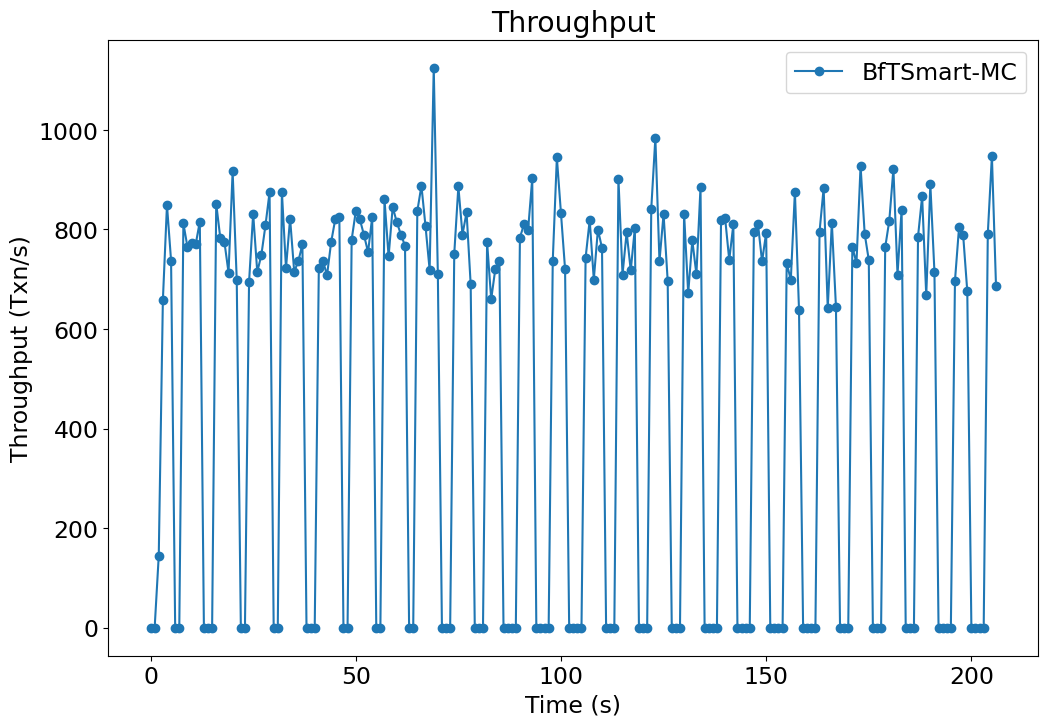

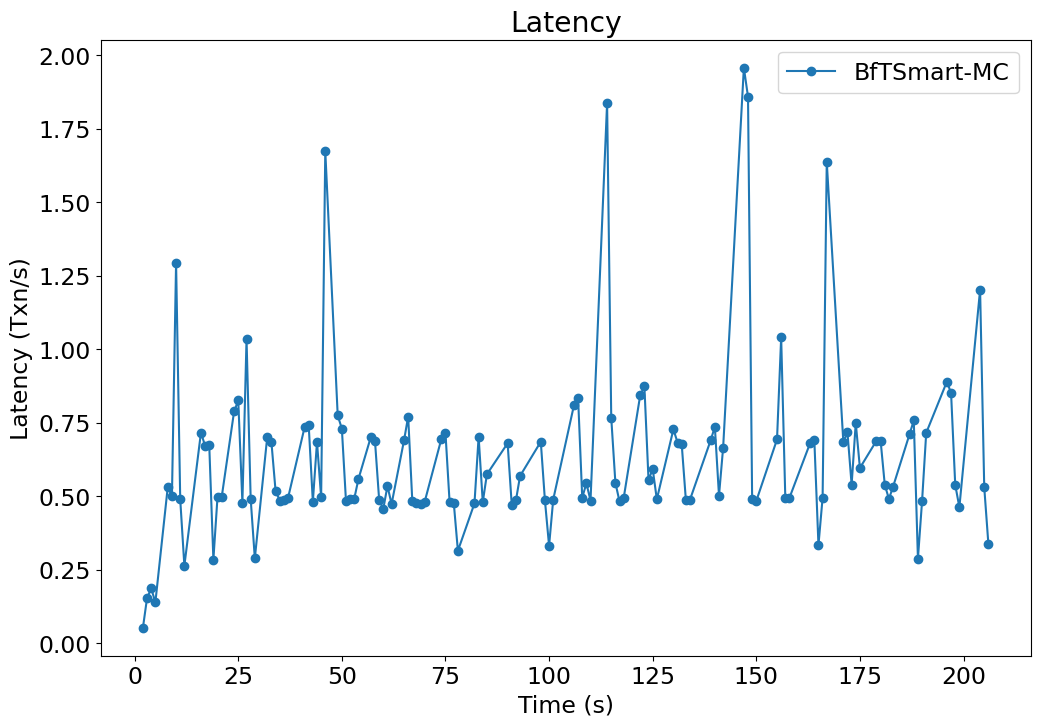

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 -1
46 -1
47 -1
48 -1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 -1
75 -1
0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'europe-west3-c'
12 12  'europe-west3-c'
13 13  'europe-west3-c'
14 14  'europe-west3-c'
15 15  'europe-west3-c'
16 16  'europe-west3-c'
17 17  'europe-west3-c'
18 18  'europe-west3-c'
19 19  'europe-west3-c'
20 20  'europe-west3-c'
21 21  'europe-west3-c'
22 22  'europe-west3-c'
23 23  'europe-west3-c'
24 24  'europe-west3-c'
25 25  'eu

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-11' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-12' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/z

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-30  europe-west3-c  e2-highmem-2               10.156.0.60  34.141.51.151  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-28].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-36].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-28  europe-west3-c  e2-highmem-2               10.156.0.66  34.141.24.210  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-36  europe-west3-c  e2-highmem-2               10.156.0.67  34.89.171.247  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-26].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-13].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-65].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-68].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-31].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-19].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-51].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'project

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-13  europe-west3-c  e2-highmem-2               10.156.0.76  34.159.15.138  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-26  europe-west3-c  e2-highmem-2               10.156.0.78  35.198.120.37  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-19  europe-west3-c  e2-highmem-2               10.156.0.127  35.198.183.53  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-31  europe-west3-c  e2-highmem-2               10.156.15.195  34.107.73.150  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-29].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-32].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-42].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-51  asia-south1-c  e2-highmem-2               10.160.0.112  35.244.28.248  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-68  asia-south1-c  e2-highmem-2               10.160.0.111  34.100.202.81  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-32  europe-west3-c  e2-highmem-2               10.156.0.124  34.107.65.45  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-16].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-39].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-48].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-29  europe-west3-c  e2-highmem-2               10.156.0.73  34.159.81.139  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-67  asia-south1-c  e2-highmem-2               10.160.0.113  34.93.18.175  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-42  europe-west3-c  e2-highmem-2               10.156.15.192  34.89.239.231  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-41].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-71].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-15].
 - The resource 'projects/ubuntu-os

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-16  europe-west3-c  e2-highmem-2               10.156.15.197  34.159.167.153  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-39  europe-west3-c  e2-highmem-2               10.156.15.199  34.159.67.102  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-65  asia-south1-c  e2-highmem-2               10.160.0.86  34.100.230.225  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-41  europe-west3-c  e2-highmem-2               10.156.15.201  34.107.50.46  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-27].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-24].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-48  europe-west3-c  e2-highmem-2               10.156.0.71  35.234.72.129  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-18].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-38].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-27  europe-west3-c  e2-highmem-2               10.156.15.202  34.159.122.110  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-24  europe-west3-c  e2-highmem-2               10.156.15.209  34.159.48.92  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-64  asia-south1-c  e2-highmem-2               10.160.0.116  35.200.143.9  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-25].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-22].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-18  europe-west3-c  e2-highmem-2               10.156.0.125  34.107.123.46  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-38  europe-west3-c  e2-highmem-2               10.156.15.198  35.242.219.59  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-44].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-35].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-20].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-14].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  europe-west3-c  e2-highmem-2               10.156.0.69  34.159.109.53  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-22  europe-west3-c  e2-highmem-2               10.156.15.200  35.246.159.109  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-60].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-69].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-44  europe-west3-c  e2-highmem-2               10.156.15.196  34.89.248.218  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-35  europe-west3-c  e2-highmem-2               10.156.0.126  34.159.122.130  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-20  europe-west3-c  e2-highmem-2               10.156.15.212  35.246.229.153  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-14  europe-west3-c  e2-highmem-2               10.156.15.207  34.159.243.95  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-71  asia-south1-c  e2-highmem-2               10.160.0.117  35.244.1.190  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-60  

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-53].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zon

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-40  europe-west3-c  e2-highmem-2               10.156.15.203  34.159.228.41  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-69  asia-south1-c  e2-highmem-2               10.160.0.123  34.93.59.140  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-25  europe-west3-c  e2-highmem-2               10.156.0.81  35.198.76.56  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-49].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-75].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-55].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-66].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-52  asia-south1-c  e2-highmem-2               10.160.0.126  35.200.233.245  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-53  asia-south1-c  e2-highmem-2               10.160.0.127  34.100.193.188  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-21].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-58].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-61].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-50  asia-south1-c  e2-highmem-2               10.160.0.85  34.93.158.4  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP  STATUS
resdb-43  europe-west3-c  e2-highmem-2               10.156.15.210  34.89.250.9  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-34].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-49  asia-south1-c  e2-highmem-2               10.160.0.122  34.47.128.190  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-21  europe-west3-c  e2-highmem-2               10.156.15.205  34.159.177.146  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-17].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zo

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-58  asia-south1-c  e2-highmem-2               10.160.0.107  34.93.158.142  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-55  asia-south1-c  e2-highmem-2               10.160.15.195  34.100.166.90  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-61  asia-south1-c  e2-highmem-2               10.160.0.110  35.200.173.223  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-37  europe-west3-c  e2-highmem-2               10.156.15.211  34.107.61.230  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-57].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-34  europe-west3-c  e2-highmem-2               10.156.15.194  34.89.182.196  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP  STATUS
resdb-17  europe-west3-c  e2-highmem-2               10.156.15.193  34.107.86.0  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-45].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-70].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-33].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-46].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-54].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-74  asia-south1-c  e2-highmem-2               10.160.15.194  35.200.205.233  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-73  asia-south1-c  e2-highmem-2               10.160.0.119  34.93.201.38  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-47].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-57  asia-south1-c  e2-highmem-2               10.160.0.121  35.200.220.181  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-33  europe-west3-c  e2-highmem-2               10.156.15.204  35.198.152.126  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-75  asia-south1-c  e2-highmem-2               10.160.15.198  34.93.35.209  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-45  europe-west3-c  e2-highmem-2               10.156.15.208  34.159.207.244  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-66  asia-south1-c  e2-highmem-2               10.160.0.115  35.200.128.206  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The res

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-46  europe-west3-c  e2-highmem-2               10.156.15.206  35.242.200.148  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-54  asia-south1-c  e2-highmem-2               10.160.0.125  34.93.128.215  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-70  asia-south1-c  e2-highmem-2               10.160.0.124  35.200.250.81  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-23].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-47  europe-west3-c  e2-highmem-2               10.156.15.213  34.89.186.125  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-56].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-23  europe-west3-c  e2-highmem-2               10.156.15.214  35.198.189.165  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-62].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-72].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-63].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-56  asia-south1-c  e2-highmem-2               10.160.15.199  35.200.163.95  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-59].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-62  asia-south1-c  e2-highmem-2               10.160.0.120  34.93.202.232  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-72  asia-south1-c  e2-highmem-2               10.160.15.192  34.93.194.192  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-63  asia-south1-c  e2-highmem-2               10.160.15.193  35.200.129.172  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-59  asia-south1-c  e2-highmem-2               10.160.0.118  34.47.131.105  RUNNING
test:  7001 10.156.15.208
test:  7002 10.156.15.206
test:  7003 10.156.15.213
test:  7004 10.156.0.71
test:  7005 10.160.0.113
test:  7006 10.160.0.111


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 3s
3 actionable tasks: 3 executed


[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 582ms
1 actionable task: 1 executed

----------


----------


----------


----------

test:  0 10.156.0.12 10000 20000 0

test:  1 10.156.0.48 10000 20000 0

test:  2 10.156.0.21 10000 20000 0

test:  3 10.156.0.8 10000 20000 0

test:  4 10.156.0.11 10000 20000 0

test:  5 10.156.0.28 10000 20000 0

test:  6 10.156.0.7 10000 20000 0

test:  7 10.156.0.36 10000 20000 0

test:  8 10.156.0.51 10000 20000 0

test:  9 10.156.0.37 10000 20000 0

test:  10 10.156.0.25 10000 20000 0

test:  11 10.156.0.30 10000 20000 0

test:  12 10.156.0.20 10000 20000 0

test:  13 10.156.0.76 10000 20000 0

test:  14 10.156.15.207 10000 20000 0

test:  15 10.156.0.69 10000 20000 0

test:  16 10.156.15.197 10000 20000 0

test:  17 10.156.15.193 10000 20000 0

test:  18 10.156.0.125 10000 20000 0

test:  19 10.156.0.127 10000 20000 0

test:  20 10.156.15.212 10000 20000 0

test:  21 10.156.15.205 10000 20000 0

test:  22 10.156.15.200 10000 20000 0

test:  23 10.156.15.214 

[detached HEAD a1758f5b] Working Post Submission: testing
 5069 files changed, 12836 insertions(+), 5128 deletions(-)
 rewrite config/keys/privatekey0 (100%)
 rewrite config/keys/privatekey1 (100%)
 rewrite config/keys/privatekey10 (100%)
 rewrite config/keys/privatekey11 (100%)
 rewrite config/keys/privatekey12 (100%)
 rewrite config/keys/privatekey13 (100%)
 rewrite config/keys/privatekey14 (100%)
 rewrite config/keys/privatekey15 (100%)
 rewrite config/keys/privatekey16 (100%)
 rewrite config/keys/privatekey17 (100%)
 rewrite config/keys/privatekey18 (100%)
 rewrite config/keys/privatekey19 (100%)
 rewrite config/keys/privatekey2 (100%)
 rewrite config/keys/privatekey20 (100%)
 rewrite config/keys/privatekey21 (100%)
 rewrite config/keys/privatekey22 (100%)
 rewrite config/keys/privatekey23 (100%)
 rewrite config/keys/privatekey24 (100%)
 rewrite config/keys/privatekey25 (100%)
 rewrite config/keys/privatekey26 (100%)
 rewrite config/keys/privatekey27 (100%)
 rewrite config/keys/pri

To github.com:tmane002/BftSmart_Final.git
   9a78b4dd..a1758f5b  HEAD -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-12.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-48.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-21.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-8.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-11.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-7.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-36.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-51.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-37.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-25.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-30.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-20.us-west-1.compute.am

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 1
22 1
23 1
24 1
25 1
26 1
27 -1
28 -1
29 -1
30 -1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 -1
47 -1
0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'europe-west3-c'
12 12  'europe-west3-c'
13 13  'europe-west3-c'
14 14  'europe-west3-c'
15 15  'europe-west3-c'
16 16  'europe-west3-c'
17 17  'europe-west3-c'
18 18  'europe-west3-c'
19 19  'europe-west3-c'
20 20  'europe-west3-c'
21 21  'europe-west3-c'
22 22  'europe-west3-c'
23 23  'europe-west3-c'
24 24  'europe-west3-c'
25 25  'europe-west3-c'
26 26  'europe-west3-c'
27 27  'europe-west3-c'
28 28  'europe-west3-c'
29 29  'europe-west3-c'
30 30  'europe-west3-c'
31 31 

In [ ]:
for cfig in config_list:    
    try:
        os.remove('node_info.csv')

        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count

        replica_count = 0

        for key in node_info_dict['cluster_id'].keys():
            if node_info_dict['cluster_id'][key] ==0:
                replica_count = replica_count + 1


        
        cluster_count = 0
        
        for key in node_info_dict['cluster_id']:
            print(key, node_info_dict['cluster_id'][key])
            if node_info_dict['cluster_id'][key] > cluster_count:
                cluster_count = node_info_dict['cluster_id'][key]
                
        cluster_count = cluster_count + 1
        
        n_clusters = cluster_count

        nclients = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])
            if node_info_dict['ServerOrClientregion'][i] == 1:
                nclients = nclients + 1
        nclients

        clusters_tracked = []
        cluster_regions_tracked = []

        for key in node_info_dict['region']:
            if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
                clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
                cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


        cluster_regions_tracked     

        cluster_regions_tracked, clusters_tracked


        regions = cluster_regions_tracked



        n_regions = len(regions)

        for i,k in enumerate(regions):
            print(i,k)

        for item, idx in enumerate(node_info_dict['region'].keys()):
            print(item, idx, node_info_dict['region'][item])

        lines  = []


        for idx, key in enumerate( node_info_dict['region'].keys()):

            line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
            lines.append(line)

        with open('launch_cloud_instances.sh', 'w') as f:
            for item in lines:
                f.write(str(item) + '\n')


        len(lines), node_info_dict['region'][key].strip()[1:-1]


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)

        time.sleep(30)
        

        # os.system('sh launch_cloud_instances.sh')

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
                shutil.rmtree(folder)


        instance_type = 'e2-small'


        redirect = '>'

        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')

        with open('all_internal_ips') as f:
            ipList = f.read().splitlines()
        ipList = [x for x in ipList if x!='None']

        ipList, len(ipList)

        new_server_only_ips= []
        new_client_only_ips= []



        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                new_server_only_ips = new_server_only_ips + [ipList[i]]
            else:
                new_client_only_ips = new_client_only_ips + [ipList[i]]



        # new_server_only_ips= []
        # new_client_only_ips= []


        # current_region_total = 0
        # for i in range(n_regions):
        #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
        #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

        #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
        #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


        #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

        new_server_only_ips, len(new_server_only_ips)

        new_client_only_ips, len(new_client_only_ips) 

        # ipList = new_server_only_ips + new_client_only_ips

        # ipList, len(ipList)

        nclients = 0
        nservers = 0
        count = 0

        clusterIpMap = {}


        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 0:
                clusterIpMap[nservers] = ipList[count]
                nservers = nservers + 1

            count = count + 1

        nclients = 0
        nservers = 0
        count = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 1:
                print('test: ', 7001+nclients, ipList[count])
                clusterIpMap[7001+nclients] = ipList[count]
                nclients = nclients + 1

            count = count + 1

        clusterIpMap

        # clusterIpMap = {}

        # for i in range(len(ipList)):
        #     clusterIpMap[i] = ipList[i]


        # for i in range(nclients):

        #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

        clusterPortMap1 = {}
        clusterPortMap2 = {}

        for i in range(len(ipList) - nclients):

            clusterPortMap1[i] = str(10000)

        for i in range(len(ipList) - nclients):
            clusterPortMap2[i] = str(20000)

        # clusterPortMap1[7003] = '11400'
        # clusterPortMap2[7003] = '11410'



        temp = 11900

        for i in range(nclients):

            clusterPortMap1[7001+i] = str(10000)
            clusterPortMap2[7001+i] = str(20000)

        clusterPortMap1, clusterPortMap2

        os.system('echo 3108 | sudo -S ./gradlew installDist')

        for i in range(total_count):
            os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

        os.system('echo 3108 | sudo -S ./gradlew clean')

        for key in clusterPortMap1.keys():
            if key>7002:
        #         print(key)
                print()

                for folder in os.listdir('config/'):
                    if os.path.isdir('config/'+folder) and 'keys' in folder:
                        if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                            shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                            shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

                print('----------')
                print()

        for i in range(n_clusters):

            if os.path.exists('config'+str(i)):
                shutil.rmtree('config'+str(i))

            os.mkdir('config'+str(i))
            os.mkdir('config'+str(i)+'/keysRSA')
            os.mkdir('config'+str(i)+'/keysSunEC')
            os.mkdir('config'+str(i)+'/keysECDSA')

        #     print('config'+str(i)+'/keysECDSA')


            shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
            shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
        #     print('config/workloads/', 'config'+str(i)+'/workloads')


            for file in os.listdir('config/keys/'):

                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


            shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
            shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





        clusterIpMap, clusterPortMap1

        def find_key_by_value(dictionary, value):
            for key, val in dictionary.items():
                if val == value:
                    return key
            # If the value is not found, you might want to handle this case accordingly.
            return None


        node_info_dict

        find_key_by_value(node_info_dict['ServerID'], 4)

        for n_cluster in range(n_clusters):

            with open('config'+str(n_cluster)+'/hosts.config','w') as file:

                for key in clusterIpMap:
                    if key < 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                        print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                for key in clusterIpMap:
                    if key >= 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                        print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

                file.close()


        # for n_cluster in range(n_clusters):

        #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

        #         for n_cluster1 in range(n_clusters):

        #             for i_replica in range(replica_count):
        #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
        #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

        #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
        #             print((n_clusters*replica_count) + iter_)

        # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
        #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

        #         for i in range(nclients):
        #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


        #         file.close()


        replica_count

        # for n_cluster in range(n_clusters):
        #     with open('config'+str(n_cluster)+'/system.config','r') as file:
        #         data = file.readlines()
        #         f = int(np.ceil((replica_count-1)/3))
        #         print('f is',f )

        #         for n_line in range(len(data)):
        #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


        #                 data[n_line] = 'system.servers.num = '+str(replica_count)
        #                 print(data[n_line])

        #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.servers.f = '+str(f)
        #                 print(data[n_line])


        #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.initial.view = '
        #                 for iter_view in range(replica_count):
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        #                     print(data[n_line])

        #                 data[n_line] = data[n_line][:-1]
        #                 print(data[n_line])



        #         file.close()

        #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
        #         for line in data:
        #             f.write(f"{line}\n")




        for n_cluster in range(n_clusters):
            with open('config'+str(n_cluster)+'/system.config','r') as file:
                data = file.readlines()


                nservers = 0
                server_id_list = []



                for i in node_info_dict['ServerOrClientregion']:
                    if node_info_dict['ServerOrClientregion'][i] == 0 and \
                    node_info_dict['cluster_id'][i]  == n_cluster:
                        nservers = nservers + 1
                        server_id_list.append(node_info_dict['ServerID'][i])

                f = int(np.ceil((nservers-1)/3))
                print('f is',f )


                for n_line in range(len(data)):
                    if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                        data[n_line] = 'system.servers.num = '+str(nservers)
                        print(data[n_line])

                    if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.servers.f = '+str(f)
                        print(data[n_line])


                    if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.initial.view = '
                        for iter_view in server_id_list:
                            data[n_line] = data[n_line] +str(iter_view)+','
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                            print(data[n_line])

                        data[n_line] = data[n_line][:-1]
                        print(data[n_line])



                file.close()

            with open('config'+str(n_cluster)+'/system.config', 'w') as f:
                for line in data:
                    f.write(f"{line}\n")


        for n_cluster in range(n_clusters):
            for i in range(999):

                for ncls in  range(1):


        #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

        # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

        os.system('git add .; git commit -m "Working Post Submission: testing";git push --force origin HEAD:main')
        

        
        

        
        
        
        
        time.sleep(30)

        # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
        # regions = [ 'us-west1-b']


        instance_type = 'e2-small'

        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data2, len(data2)

        data = []

        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict









        # time.sleep(60)

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count





        def getTimeThps(file, flag):

            f = open(file, "r")
            data = f.readlines() 

            times = []
            thputs = []
            for line in data:
                if 'throughput[ops/s]' in line:
                    lineData = (line[13+line.find('max[ops/s])>'):-2])
                    print(lineData)

                    times.append(lineData.split('|')[0])
                    thputs.append(lineData.split('|')[-2])
            if (flag): 
                times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
                thputs.append(0)

            return np.array(times).astype(float), np.array(thputs).astype(float) 

        with open('all_external_ips') as f:
            lines = f.read().splitlines()


        lines = [x for x in lines if x!='None']
        lines, len(lines)

        for ip in lines:
            if ip!='None':
                current = (ip.split('.'))

                print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

        ## Set number of clusters

        nclusters = 0

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config':
                nclusters = nclusters + 1


        print(nclusters)





        nreplicas = int(total_count/nclusters)
        
        nclients = 0
        
        for key in node_info_dict['ServerOrClientregion']:
            if node_info_dict['ServerOrClientregion'][key]==1:
                nclients = nclients + 1
        


        nodeIps = []
        clientIps = []

        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                nodeIps.append(lines[i])
            else:
                clientIps.append(lines[i])


        # nodeIps = lines[:nclusters* nreplicas]


        # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
        no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]


        experiment = 'bft_mc_'+cfig 

        # clientIps = lines[-(nclusters):]



        # clientIps = lines[-nclients:]



        clientIps, no_cluster_yet_nodes



        node_info_dict

        node_info_dict['region'][0].strip()

        ## Functions

        def setup(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

                print(command)
                os.system(command)

        def initialize(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


                os.system(command)


        def git_clone(i):
            ip = lines[i]
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


                os.system(command)

        def git_pull(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


                os.system(command)

        def compile_job(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


                os.system(command)



        def clean_job(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm config/currentView; '
            for iter_ in range(nclusters):
                rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


                os.system(command)


        def clean_all(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


                os.system(command)





        #     if ip!='None' and( ip in no_cluster_yet_nodes):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


        #         os.system(command)        
        # #         print(command)

        def check_node(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


                os.system(command)
        #         print(command)


        def run_basic_client(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                cmd_arg = str(node_info_dict['clientID'][i])



                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


                os.system(command)


        def kill_java(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                os.system(command)



        def kill_clients(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and ip in clientIps:
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


                os.system(command)

        def run_server_node_check(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


                print(command)



        # for i in range(len(lines)):
        #     run_server_node_check(i)

        def run_basic_client_check(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                cmd_arg = str(node_info_dict['clientID'][i])


        #         print(i, cmd_arg)

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


                print(command)



        ## First Time Setup

        lines, len(lines)

        # for i in range(10):
        #     setup(i)


        results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
        print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
        print(results)  

        # ## GIT Clone/Pull



        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


        # print(results)  

        # ## Compile Job

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        print(results)  

        # ## CLEAN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        # print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


        def run_server_node(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


                os.system(command)



        # for i in node_info_dict['publicIP']:
        #     run_server_node(i)

        ## RUN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  

        ### CHECK NODE RESULT

        # check_node(0)

        # ## Run basic client

        # # time.sleep(20)
        # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
        # print(results)  

        # check_node(0)

        # time.sleep(60)

        # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

        ## Main Job

        # os.system('git add .; git commit -m "test";git push')


        # time.sleep(60)

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push --force origin HEAD:main')

# if 2>1:
#     if 2>1:
        
        #     %%time


        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        # print(results) 





        results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


        results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  


        print('XXXXXXXX Started Servers XXXXXXXXXXXX')

        time.sleep(40)

        check_node(7)

        print('XXXXXXXX Started Clients XXXXXXXXXXXX')

        results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

        time.sleep(80)
#         results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
        time.sleep(120)

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        check_node(0)

        if not os.path.exists('../Experiments/'+experiment):
            os.mkdir('../Experiments/'+experiment)

        os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

                break;



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 



            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)


        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            print(i)
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)


        node_info_dict

        clientIps




        def getTimesThputs(file):
            f = open(file, "r")
            data = f.readlines() 
            times = []
            thputs = []
            latencies = []
            for line in data:
        #         print(line)
                if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

        #         print(line)
                    times.append(line.split('sec:')[0].strip())
                    thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
                    read_lat = '0'
                    write_lat = '0'
                    
                    if ('READ AverageLatency' in line):
                        
                        print(line)

                        read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
                    if ('UPDATE AverageLatency' in line):                    
                        
                        write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


                    if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                        latencies.append(line.split('=')[1].split(']')[0].strip())
                    else:
                        read_frac = 0
                        write_frac = 0
                        
                        if float(read_lat) > 0:
                            read_frac = 0.85
                            
                        if float(write_lat) > 0:
                            write_frac = 0.15
                            
#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))
                        
                        lat = str( (write_frac * float(write_lat) +\
                                    read_frac*float(read_lat))/(write_frac+read_frac)\
                                 )
                        latencies.append(lat)

                    print(line,latencies[-1],thputs[-1],times[-1])

            return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


        times_thputsDict = {}
        times_latsDict = {}


        for ip in clientIps[:1]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

            print(times, thputs)
            for i in range(len(times)):
                times_thputsDict[times[i]] = thputs[i]
                times_latsDict[times[i]] = lats[i]


        for ip in clientIps[1:]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


            for i in range(len(times)):

                if times[i] in times_thputsDict.keys():
                    times_thputsDict[times[i]] += thputs[i]

                if times[i] in times_latsDict.keys():
                    times_latsDict[times[i]] += lats[i]


        times_thputsDict



        PIK = '../Experiments/'+experiment+"/pickle.dat"

        data = [times_thputsDict, times_latsDict]

        with open(PIK, "wb") as f:
            pickle.dump(data, f)

        experiment

        # experiment = 'TestRun2_8_clusters_2'
        # PIK = '../Experiments/'+experiment+"/pickle.dat"

        data2 = []
        
        with open(PIK, "rb") as f:
            data2 =  pickle.load(f)


        dict1 = data2[0]
        dict2 = data2[1]



        times1 = np.array(list(dict1.keys()))
        thputs = np.array(list(dict1.values()))

        times2 = np.array(list(dict2.keys()))
        lats = np.array(list(dict2.values()))

        

        

        times_new = [x for x in range(1+int(times1[-1]))]
        thputs_new = [0 for x in range(1+int(times1[-1]))]

        for idx, t in enumerate(times1):
            thputs_new[int(t)] = thputs[idx]

    

        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()




        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


        pl.title(r'Latency')


        pl.xlabel('Time (s)')
        pl.ylabel('Latency (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
        pl.show()

        times1, lats

        lats, np.average(lats[-85:-5])/len(clientIps)

        np.sum(thputs),  np.average(thputs[-85:-5])

        thputs

        np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

        # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

        np.sum((thputs[:180]))

        np.sum((thputs[:180]))
        
        
        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

                break;




#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')

    except:
        
#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
        
        continue
    


In [ ]:



for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 



    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        print('client copying id= ',i)
        current = (ip.split('.'))
        command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)


In [ ]:
np.average(lats)/nclusters

In [ ]:
np.average(thputs[60:80])

In [ ]:
n_clusters